In [1]:
import pandas as pd
import geohash
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [2]:
master_df = pd.read_csv('my_featured_data.csv')
master_df = master_df.drop(master_df.columns[0], axis=1)
master_df.head(5)

,latStart,lonStart,latEnd,lonEnd,week,dayofweek,cluster,hours
0,40.680820,-73.940613,40.718063,-73.98555,5,0,4,0
1,40.746876,-73.890312,40.718063,-73.98555,5,0,4,2
2,40.680794,-73.946198,40.718063,-73.98555,5,0,4,3
3,40.824635,-73.873390,40.718063,-73.98555,5,0,4,3
4,40.810658,-73.958031,40.718063,-73.98555,5,0,4,4


In [149]:
master_df.columns

Index(['latStart', 'lonStart', 'latEnd', 'lonEnd', 'week', 'dayofweek',
       'cluster'],
      dtype='object')

In [3]:
master_df["end_corr"] = master_df["latEnd"].astype("str") + "," + master_df["lonEnd"].astype("str")

### Train-test split


In [4]:
columns_all_features = master_df.columns
columns_X = ['latStart', 'lonStart', 'week', 'dayofweek',
       'cluster', 'hours']
columns_y = ['end_corr']
X = master_df[columns_X]
y = master_df[columns_y]

In [5]:
from sklearn.model_selection import train_test_split

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

### Machine Learning

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

#### Grid Search Cross Validation
Grid Search CV implements an exhaustive search over specified parameter values for an estimator.
Important members are fit, predict.

It iterates through a dictionary of hyper parameters and choose the combination that better fits the model.

In [17]:
from sklearn.model_selection import GridSearchCV
# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': [2, 5, 10, 20, 40], 'max_depth': [None, 1, 2, 3, 4], 'min_samples_split': [2, 3, 4, 5, 6]}


# clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
gridCV = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, n_jobs=-1, verbose=1)
gridCV.fit(X_train, y_train)
print (gridCV.best_estimator_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 618 out of 625 | elapsed:   20.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:   20.5s finished
/home/artig/miniconda3/envs/mlflow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestClassifier(min_samples_split=4, n_estimators=40)


In [18]:
best_model = gridCV.best_estimator_
training_accuracy = best_model.score(X_train, y_train)
valid_accuracy = best_model.score(X_test, y_test)
print("training accuracy    : {}".format(training_accuracy*100))
print("testing accuracy     : {}".format(valid_accuracy*100))

training accuracy    : 99.94859933179131
testing accuracy     : 99.40047961630695


#### Forest feature importances
Feature importance shows a coefficient of how much a feature is involved in the decision process of the model. It help us to detect bias in the model, and to make a readjust and better feature selection 

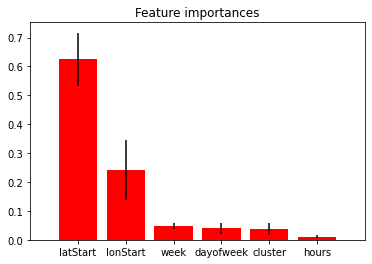

In [19]:
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest
feature_names = X_train.columns
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Save the model
We dump the trained model into a file, so that we can later load and use it without having to fit it again

In [20]:
joblib.dump(best_model, 'RFC_model.pkl') 

['RFC_model.pkl']

In [6]:
X_test

,latStart,lonStart,week,dayofweek,cluster,hours
3807,40.793106,-73.945648,7,5,1,10
551,40.802380,-73.943138,5,3,1,6
3021,40.680439,-73.949394,7,1,2,17
3623,40.816589,-73.946785,7,4,0,14
77,40.816544,-73.942932,5,0,0,12
...,...,...,...,...,...,...
1045,40.809689,-73.949509,5,5,0,14
656,40.809273,-73.951782,5,3,0,16
3599,40.695915,-73.983414,7,4,0,12
4684,40.759125,-73.919128,8,3,1,10
